# Clasificador de imagenes (Vegetales)

Red que reconoce 7 tipos distintos de vegetales. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes motamos nuestro sistema de archivos de Google Drive para hacerlo accesible.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora ya es accesible

Verificamos que realmente estamos utilizando una GPU

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Abrimos una imagen para confirmar que las rutas de drive funcionan

0  1  2  3  4  5  6


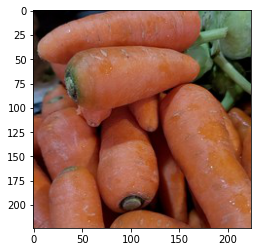

In [3]:
!ls "/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/train/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/train/0/0265.jpg', 'r')
imshow(np.asarray(pil_im))



## Primer modelo

In [4]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150) #En realidad 224x224 pixeles lo que mide la imagen
batch_size = 32 #Por ejemplo, supongamos que tiene 1050 muestras de entrenamiento y desea configurar un valor batch_sizeigual a 100. El algoritmo toma las primeras 100 muestras (del 1 al 100) del conjunto de datos de entrenamiento y entrena la red. Luego, toma las segundas 100 muestras (
train_ds = tf.keras.preprocessing.image_dataset_from_directory(  #leerá automáticamente las imágenes y creará un conjunto de datos y etiquetas.
    "/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Según la documentación de tf.keras.utils.image_dataset_from_directory , admite cuatro tipos de label_mode :
#'int': significa que las etiquetas están codificadas como números enteros (por ejemplo, para sparse_categorical_crossentropypérdida).
#'categórico' significa que las etiquetas están codificadas como un vector categórico (p. ej., para pérdida de entropía cruzada categórica).
#'binario' significa que las etiquetas (solo puede haber 2) están codificadas como escalares float32 con valores 0 o 1 (por ejemplo, para binary_crossentropy).
#Ninguno (sin etiquetas).

val_ds = tf.keras.preprocessing.image_dataset_from_directory(#leerá automáticamente las imágenes y creará un conjunto de datos y etiquetas.
    "/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'# se cambio a int desde categorical debido a que es necesario para usar sparse_categorical_crossentropy
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 3500 files belonging to 7 classes.
Using 2800 files for training.
Found 3500 files belonging to 7 classes.
Using 700 files for validation.


In [5]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3))) #Capa de entrada 150x150 píxeles y 3 canales RGB falta un primer elemento que es None que corresponde con el numero de  muestras

#capa 1
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#lo que hacen estas capas es, para un tamaño dado (por ejemplo, 2x2 píxeles) reducir cada región del input de ese tamaño a un único píxel con el valor medio/máximo
model.add(Dropout(0.3))
#capa 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#capa 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#capa 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#capa 6
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#capa 7
model.add(Flatten()) #La instrucción Flatten convierte los elementos de la matriz de imagenes de entrada en un array plano. 
model.add(Dense(512, activation='relu')) # la instrucción Dense, añadimos una capa oculta (hidden layer) de la red neuronal de 128 nodos
model.add(Dropout(0.5))
#capa 8
model.add(Dense(7, activation='softmax')) # 7 nodos para la capa de salida correspondiente a las clases

model.compile(loss=tf.keras.losses.categorical_crossentropy, # se cambio de categorical_crossentropy a sparse_categorical_crossentropy si int
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [6]:
# TRAINING --------------------------------------------------

epochs = 150 #Entonces, en otras palabras, un número de épocas significa cuántas veces pasas por tu conjunto de entrenamiento por cada batch.

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        print("llega"), 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

llega
Epoch 1/150
88/88 [==============================] - 511s 5s/step - loss: 1.5822 - accuracy: 0.3546 - val_loss: 1.1631 - val_accuracy: 0.6414
Epoch 2/150
88/88 [==============================] - 7s 79ms/step - loss: 0.8829 - accuracy: 0.6529 - val_loss: 0.6610 - val_accuracy: 0.7614
Epoch 3/150
88/88 [==============================] - 7s 77ms/step - loss: 0.5407 - accuracy: 0.8154 - val_loss: 0.7800 - val_accuracy: 0.7300
Epoch 4/150
88/88 [==============================] - 7s 79ms/step - loss: 0.3741 - accuracy: 0.8721 - val_loss: 0.5224 - val_accuracy: 0.8271
Epoch 5/150
88/88 [==============================] - 7s 78ms/step - loss: 0.3491 - accuracy: 0.8957 - val_loss: 0.4729 - val_accuracy: 0.8557
Epoch 6/150
88/88 [==============================] - 7s 77ms/step - loss: 0.2932 - accuracy: 0.9011 - val_loss: 0.4124 - val_accuracy: 0.8600
Epoch 7/150
88/88 [==============================] - 8s 81ms/step - loss: 0.2457 - accuracy: 0.9200 - val_loss: 0.4111 - val_accuracy: 0.8571


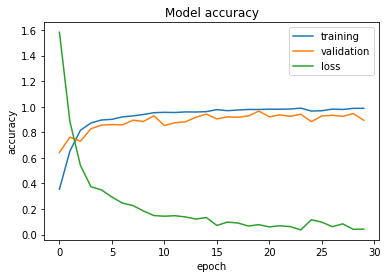

In [7]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right') # cambiar escala
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 85ms/step
              precision    recall  f1-score   support

           0     0.9794    0.9896    0.9845        96
           1     1.0000    0.9787    0.9892        94
           2     0.9238    0.9604    0.9417       101
           3     0.9907    0.9817    0.9862       109
           4     0.9798    0.9898    0.9848        98
           5     0.9712    0.9266    0.9484       109
           6     0.9158    0.9355    0.9255        93

    accuracy                         0.9657       700
   macro avg     0.9658    0.9660    0.9658       700
weighted avg     0.9662    0.9657    0.9658       700



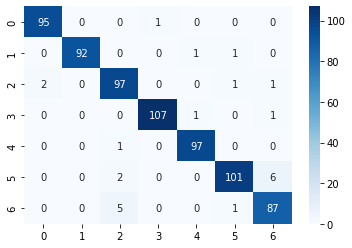

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [9]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/train/1/0001.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 169ms/step
1


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
28
1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0     0.9794    0.9896    0.9845        96
           1     1.0000    0.9787    0.9892        94
           2     0.9238    0.9604    0.9417       101
           3     0.9907    0.9817    0.9862       109
           4     0.9798    0.9898    0.9848        98
           5     0.9712    0.9266    0.9484       109
           6     0.9158    0.9355    0.9255        93

    accuracy                         0.9657       700
   macro avg     0.9658    0.9660    0.9658       700
weighted avg     0.9662    0.9657    0.9658       700



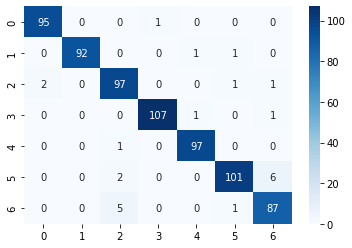

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for x, y in val_ds:
  print(len(y))

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

# OBTENEMOS RESUMEN DEL MODELO

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                    

# GUARDAR MODELO ENTRENADO


In [12]:

# serializar el modelo a JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Redes Neuronales/Trabajo/Versión 2 - Arquitectura Personalizada Mejorada/Versión 2.2 (Sin)/3 Configuracion/model.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("/content/drive/My Drive/Redes Neuronales/Trabajo/Versión 2 - Arquitectura Personalizada Mejorada/Versión 2.2 (Sin)/3 Configuracion/model.h5")
print("Modelo Guardado!")

Modelo Guardado!


# CARGAMOS EL MODELO YA ENTRENADO

In [13]:
from keras.models import model_from_json
import tensorflow as tf
# cargar json y crear el modelo
json_file = open("/content/drive/My Drive/Redes Neuronales/Trabajo/Versión 2 - Arquitectura Personalizada Mejorada/Versión 2.2 (Sin)/3 Configuracion/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model =  model_from_json(loaded_model_json)
# cargar pesos al nuevo modelo
loaded_model.load_weights("/content/drive/My Drive/Redes Neuronales/Trabajo/Versión 2 - Arquitectura Personalizada Mejorada/Versión 2.2 (Sin)/3 Configuracion/model.h5")
print("Cargado modelo desde disco.")
 
# Compilar modelo cargado y listo para usar.
#loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])
loaded_model.compile(loss=tf.keras.losses.categorical_crossentropy, # se cambio de categorical_crossentropy a sparse_categorical_crossentropy si int
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Cargado modelo desde disco.


# USAMOS EL MODELO ENTREANDO

In [14]:
def  classification_report(nombre_archivo, numero):
  
  if numero == 0:
    return(nombre_archivo+": Carrot")
  if numero == 1:
    return(nombre_archivo+": Papaya")
  if numero == 2:
    return(nombre_archivo+": Tomato")
  if numero == 3:
    return(nombre_archivo+": Potato")
  if numero == 4:
    return(nombre_archivo+": Capsicum")
  if numero == 5:
    return(nombre_archivo+": Broccoli")
  if numero == 6:
    return(nombre_archivo+": Pummking")

  return 0;

In [15]:
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import os

image_size = (150, 150) #En realidad 224x224 pixeles lo que mide la imagen
contenido = os.listdir('/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/test/a/')
for i in contenido:
  img = keras.preprocessing.image.load_img(
      '/content/drive/My Drive/Redes Neuronales/Trabajo/dataset/test/a/'+i, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = loaded_model.predict(img_array)
  print(classification_report(i, np.argmax(predictions[0])))

#test_lost, test_acc= loaded_model.evaluate(val_ds)
#print ("Test Accuracy:", test_acc)


1/1 [==============================] - 0s 89ms/step
carrot.jpg: Carrot
1/1 [==============================] - 0s 17ms/step
potato.jpg: Potato
1/1 [==============================] - 0s 15ms/step
istockphoto-172278932-612x612.jpg: Carrot
1/1 [==============================] - 0s 20ms/step
istockphoto-821597910-612x612.jpg: Tomato
1/1 [==============================] - 0s 15ms/step
istockphoto-1061905230-612x612.jpg: Carrot
1/1 [==============================] - 0s 16ms/step
istockphoto-160060077-612x612.jpg: Tomato
1/1 [==============================] - 0s 27ms/step
istockphoto-1332513552-612x612.jpg: Potato
1/1 [==============================] - 0s 20ms/step
istockphoto-1209222852-612x612.jpg: Carrot
1/1 [==============================] - 0s 15ms/step
istockphoto-648533122-612x612.jpg: Pummking
1/1 [==============================] - 0s 17ms/step
istockphoto-618540744-612x612.jpg: Pummking
1/1 [==============================] - 0s 15ms/step
istockphoto-1000521354-612x612.jpg: Carrot
1/1 